# Advanced Latent Optimization Strategies

This notebook trains a small demo model on the sample polymer data (density target) and then explores `optimize_latent` strategies:
1. Data-driven initialization (seeds from descriptors)
2. Perturbation to escape local optima
3. Multi-restart for global search
4. Comparison of different starting strategies


In [3]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib

from pymatgen.core.composition import Composition

from pathlib import Path

from foundation_model.models.flexible_multi_task_model import FlexibleMultiTaskModel
from foundation_model.models.model_config import (
    MLPEncoderConfig,
    RegressionTaskConfig,
    AutoEncoderTaskConfig,
    OptimizerConfig,
)

from foundation_model.utils.kmd_plus import (
    KMD,
    element_features,  # Element-level descriptors of shape (94, 58).
    formula_to_composition,
)

torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✓ Libraries loaded (device={device})")


✓ Libraries loaded (device=cpu)


In [2]:
def decoded_weight_to_composition(decoded_weight, component_features, *, min_ratio=0.0):
    """
    Convert decoded weights to a list of composition dictionaries.
    Elements with ratio < min_ratio are filtered out, and their mass is
    redistributed evenly among the remaining elements.
    All ratios are normalized to 0.005 intervals.

    Args:
        decoded_weight: numpy array of shape (n_samples, n_elements) containing element ratios
        component_features: pandas DataFrame with element symbols as index
        min_ratio: minimum ratio threshold for keeping an element (default: 0.0)

    Returns:
        List of dictionaries, each mapping element symbols to their ratios
    """
    compositions = []
    element_symbols = component_features.index.tolist()

    for i in range(decoded_weight.shape[0]):
        # Get non-zero ratios
        raw_composition = {}
        for j, element in enumerate(element_symbols):
            ratio = decoded_weight[i, j]
            if ratio > 0:
                raw_composition[element] = ratio.item()

        # Filter ratios >= min_ratio
        filtered_composition = {k: v for k, v in raw_composition.items() if v >= min_ratio}

        if not filtered_composition:
            # If all ratios < min_ratio, keep the largest one
            if raw_composition:
                max_element = max(raw_composition, key=raw_composition.get)
                compositions.append({max_element: 1.0})
            else:
                compositions.append({})
            continue

        # Calculate total mass to redistribute
        total_mass = sum(raw_composition.values())
        filtered_mass = sum(filtered_composition.values())
        redistributed_mass = total_mass - filtered_mass

        # Redistribute evenly among remaining elements
        num_remaining = len(filtered_composition)
        redistribution_per_element = redistributed_mass / num_remaining

        # Apply redistribution and normalize to 0.005 intervals
        final_composition = {}
        for element, ratio in filtered_composition.items():
            new_ratio = ratio + redistribution_per_element
            # Round to nearest 0.005
            normalized_ratio = round(new_ratio / 0.005) * 0.005
            final_composition[element] = normalized_ratio

        compositions.append(final_composition)

    return compositions

In [4]:
target_path = Path('../data/qc_ac_te_mp_dos_reformat_20250615.pd.parquet')


# Load the dataset for the KmdPlus tutorial.
# Chemical formulas of all stable materials listed in Materials Project (2022/08/07), and their formation energies.
MP_stable = pd.read_parquet(target_path)
MP_stable.composition = MP_stable.composition.apply(lambda x: {k: v for k, v in x.items() if v is not None})

fliter = [Composition.from_dict(comp).valid for comp in MP_stable.composition]
MP_stable = MP_stable[fliter]
MP_stable

,formula,Material type,Space group,composition,elements,Band gap,Density,Efermi,Final energy per atom,Formation energy per atom,...,Electrical resistivity (normalized),Power factor (normalized),Seebeck coefficient (normalized),Thermal conductivity (normalized),ZT (normalized),Magnetic susceptibility (normalized),DOS energy,DOS density,DOS density (normalized),split
id,,,,,,,,,,,,,,,,,,,,,
mp-111,Ne,others,Fm-3m,{'Ne': 1.0},[Ne],11.6898,1.815607,-9.772494,-1.912824,0.000000,...,None,None,None,None,None,None,None,None,None,val
mp-23158,He,others,Im-3m,{'He': 1.0},[He],17.6377,0.384324,-13.591344,-0.313901,0.000000,...,None,None,None,None,None,None,None,None,None,train
mp-23155,Ar,others,Fm-3m,{'Ar': 1.0},[Ar],8.5132,1.720053,-5.482198,-4.858515,0.000000,...,None,None,None,None,None,None,None,None,None,train
mp-1525632,F2,others,Cmce,{'F': 4.0},[F],2.8979,2.366529,-4.635707,-3.126028,0.000000,...,None,None,None,None,None,None,None,None,None,val
mp-1095223,OF2,others,Pnma,"{'F': 8.0, 'O': 4.0}","[F, O]",2.1241,2.196288,-2.171794,-3.421278,-0.496056,...,None,None,None,None,None,None,None,None,None,val
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mp-1201016,Cs9Fe2Se7,others,P2_13,"{'Cs': 36.0, 'Fe': 8.0, 'Se': 28.0}","[Cs, Fe, Se]",0.5130,4.183524,1.776250,-3.858616,-1.103992,...,None,None,None,None,None,None,None,None,None,test
mp-581173,Cs10Si7O9,others,P2/c,"{'Cs': 40.0, 'O': 36.0, 'Si': 28.0}","[Cs, O, Si]",1.4150,3.676090,2.604339,-5.347066,-1.824426,...,None,None,None,None,None,None,None,None,None,train
mp-582182,Cs5In3As4,others,P2_1/c,"{'As': 32.0, 'Cs': 40.0, 'In': 24.0}","[As, Cs, In]",0.9419,4.834335,3.608423,-3.032848,-0.408023,...,None,None,None,None,None,None,None,None,None,train


In [5]:
# Convert chemical formulas to compositions.
MP_weight = MP_stable.composition.apply(formula_to_composition)
MP_weight = np.stack(MP_weight.values)
component_features = element_features

MP_weight.shape
component_features.shape

(94, 58)

In [6]:
# Generate the kernel mean descriptors (KMD) for each feature, then combine them.
kmd_1d = KMD("1d")  # Unidimensional KMD; the kernel mean is discretized at the n_grids equally spaced grids

# Generate 2 types of descriptors with the default settings (materials → descriptors).
kmd1d = kmd_1d.transform(MP_weight, component_features, 10)

# Add index to the KMD DataFrame.
kmd1d_desc = pd.DataFrame(kmd1d, index=MP_stable.index)

/Users/liuchang/projects/foundation_model/src/foundation_model/utils/kmd_plus.py:160: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grid_points = np.linspace(min_cf[i], max_cf[i], n_grids)


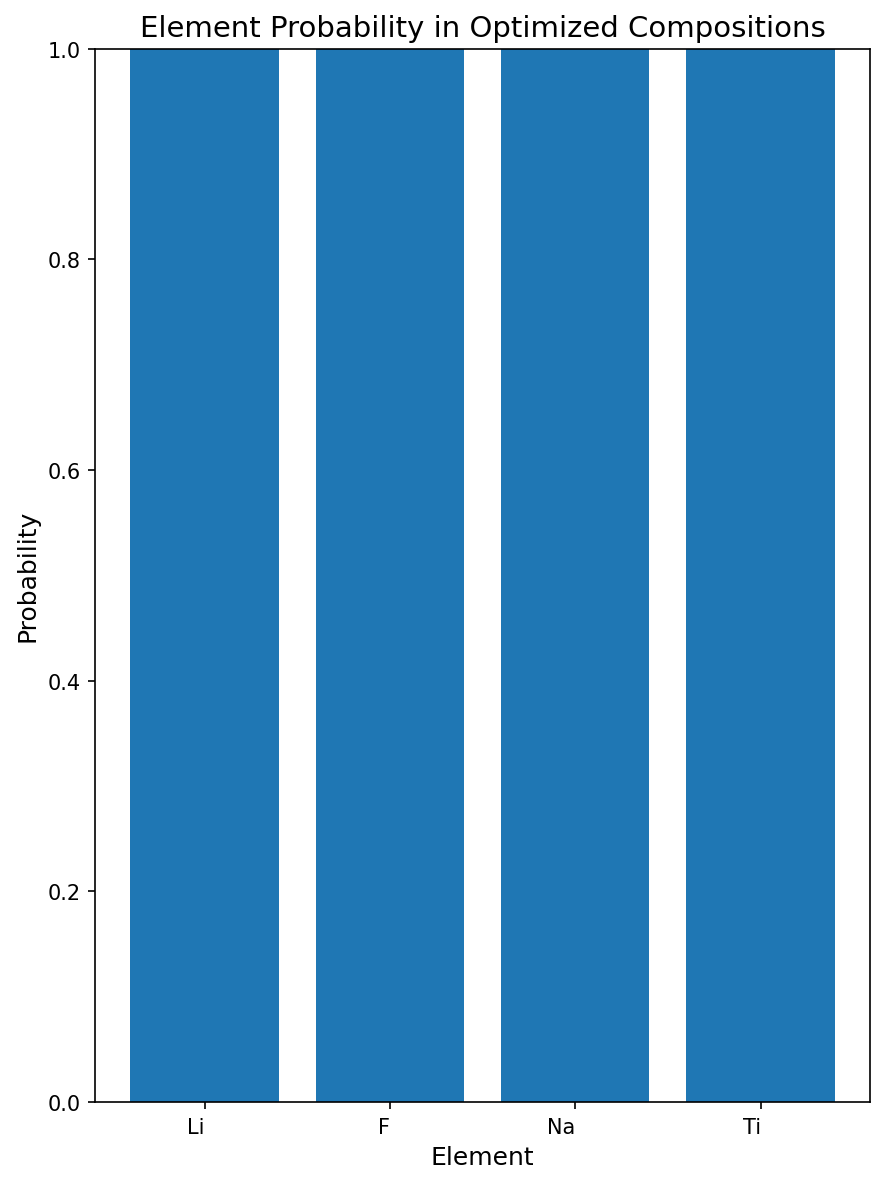

[{'Li': 0.22, 'F': 0.225, 'Na': 0.255, 'Ti': 0.305},
 {'Li': 0.21, 'F': 0.22, 'Na': 0.26, 'Ti': 0.31},
 {'Li': 0.22, 'F': 0.23, 'Na': 0.25, 'Ti': 0.3},
 {'Li': 0.2, 'F': 0.215, 'Na': 0.265, 'Ti': 0.32},
 {'Li': 0.20500000000000002, 'F': 0.215, 'Na': 0.265, 'Ti': 0.315},
 {'Li': 0.20500000000000002, 'F': 0.22, 'Na': 0.26, 'Ti': 0.315},
 {'Li': 0.23, 'F': 0.215, 'Na': 0.255, 'Ti': 0.305},
 {'Li': 0.22, 'F': 0.225, 'Na': 0.25, 'Ti': 0.3},
 {'Li': 0.20500000000000002, 'F': 0.22, 'Na': 0.26, 'Ti': 0.315},
 {'Li': 0.22, 'F': 0.225, 'Na': 0.255, 'Ti': 0.305},
 {'Li': 0.20500000000000002, 'F': 0.215, 'Na': 0.26, 'Ti': 0.315},
 {'Li': 0.215, 'F': 0.225, 'Na': 0.255, 'Ti': 0.305},
 {'Li': 0.21, 'F': 0.215, 'Na': 0.26, 'Ti': 0.315},
 {'Li': 0.21, 'F': 0.22, 'Na': 0.26, 'Ti': 0.31},
 {'Li': 0.215, 'F': 0.215, 'Na': 0.26, 'Ti': 0.31},
 {'Li': 0.215, 'F': 0.225, 'Na': 0.255, 'Ti': 0.305},
 {'Li': 0.21, 'F': 0.22, 'Na': 0.26, 'Ti': 0.31},
 {'Li': 0.22, 'F': 0.215, 'Na': 0.255, 'Ti': 0.31},
 {'Li': 0.

In [ ]:
decoded_weight = kmd_1d.inverse_transform(result_latent.optimized_input[50])
optimized_comps = decoded_weight_to_composition(decoded_weight, component_features, min_ratio=0.1)
# Count element frequencies across all compositions
element_counts = {}
for comp in optimized_comps:
    for element in comp.keys():
        element_counts[element] = element_counts.get(element, 0) + 1

# Calculate probabilities
total_compositions = len(optimized_comps)
element_probs = {element: count / total_compositions for element, count in element_counts.items()}

# Sort by probability
sorted_elements = sorted(element_probs.items(), key=lambda x: x[1], reverse=True)
elements, probs = zip(*sorted_elements)

# Create bar plot
plt.figure(figsize=(6, 8), dpi=150)
plt.bar(elements, probs)
plt.xlabel('Element', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.title('Element Probability in Optimized Compositions', fontsize=14)
plt.xticks(rotation=0, ha='right')
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

optimized_comps

## Train a quick model using sample polymer data

We load descriptors/targets from `samples/dynamic_task_suite_config.toml` paths, fit a small model on `density`, and reuse that model for latent optimization.


Epoch 50: loss=0.1872
Epoch 100: loss=0.1720
Epoch 150: loss=0.1047
Epoch 200: loss=0.0665
Epoch 250: loss=0.0737
Epoch 300: loss=0.0570
Epoch 350: loss=0.0787
Epoch 400: loss=0.0485
Epoch 450: loss=0.0906
Epoch 500: loss=0.0457
Training complete. Samples used: 3604, input_dim=580


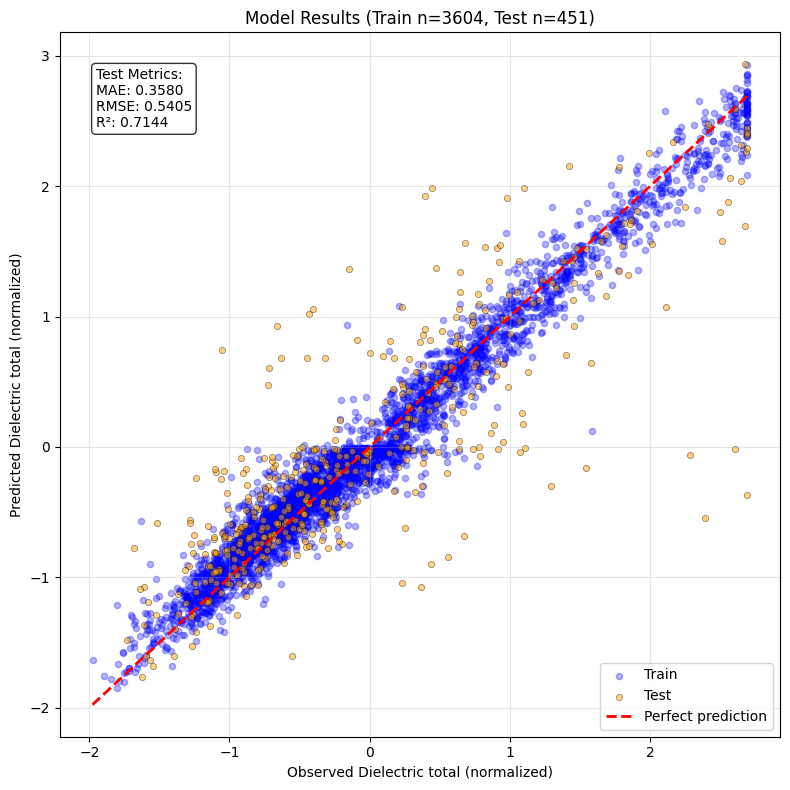


Train Set Metrics:
  MAE:  0.1369
  RMSE: 0.1808
  R²:   0.9673

Test Set Metrics:
  MAE:  0.3580
  RMSE: 0.5405
  R²:   0.7144

AutoEncoder Reconstruction Metrics (Test Set):
  MSE: 0.001055
  MAE: 0.020153


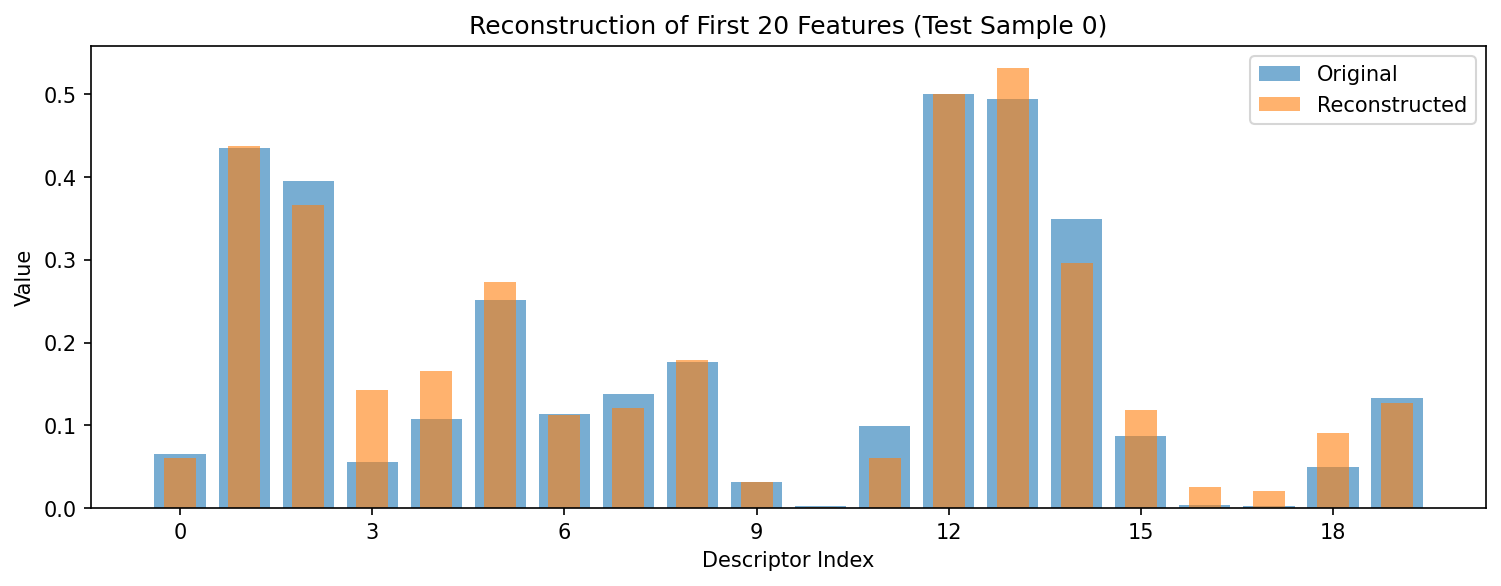

['../data/test_reconstruct.pkl.z']

In [2]:
from loguru import logger as fm_logger
from matplotlib.ticker import MaxNLocator
fm_logger.disable("foundation_model")

target_name = 'Dielectric total (normalized)'
# target_name = 'Dielectric ionic (normalized)'
# target_name = 'Dielectric electronic (normalized)'

descriptor_path = Path('../data/qc_ac_te_mp_dos_kmd1d_desc_20250615.pd.parquet')
target_path = Path('../data/qc_ac_te_mp_dos_reformat_20250615.pd.parquet')

properties = pd.read_parquet(target_path)[[target_name, target_name[:-13], "composition"]]
properties.composition = properties.composition.apply(lambda x: {k: v for k, v in x.items() if v is not None})
properties = properties[properties[target_name[:-13]] < 1000]
descriptors = pd.read_parquet(descriptor_path).loc[properties.index]

# Merge and keep numeric descriptor columns
merged = descriptors.join(properties).dropna(subset=[target_name])
descriptor_cols = [c for c in descriptors.columns if pd.api.types.is_numeric_dtype(descriptors[c])]
X_full = torch.tensor(merged[descriptor_cols].values, dtype=torch.float32)
y_full = torch.tensor(merged[target_name].values, dtype=torch.float32).unsqueeze(1)

max_samples = 50000
if len(X_full) > max_samples:
    X_full = X_full[:max_samples]
    y_full = y_full[:max_samples]

# Split into train (80%), val (10%), test (10%)
n_samples = len(X_full)
indices = torch.randperm(n_samples)
n_train = int(0.8 * n_samples)
n_val = int(0.1 * n_samples)

train_idx = indices[:n_train]
val_idx = indices[n_train:n_train+n_val]
test_idx = indices[n_train+n_val:]

X = X_full[train_idx].to(device)
y = y_full[train_idx].to(device)
X_val = X_full[val_idx].to(device)
y_val = y_full[val_idx].to(device)
X_test = X_full[test_idx].to(device)
y_test = y_full[test_idx].to(device)

input_dim = X.shape[1]
latent_dim = 128

encoder_config = MLPEncoderConfig(hidden_dims=[input_dim, 256, latent_dim], norm=True)
density_task = RegressionTaskConfig(
    name=target_name,
    data_column=target_name,
    dims=[latent_dim, 64, 32, 1],
    norm=True,
)
ae_task = AutoEncoderTaskConfig(
    name='reconstruction',
    data_column='__autoencoder__',
    dims=[latent_dim, 256, input_dim],
    norm=True,
)

model = FlexibleMultiTaskModel(
    encoder_config=encoder_config,
    task_configs=[density_task, ae_task],
    shared_block_optimizer=OptimizerConfig(lr=5e-3),
).to(device)

dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=256, shuffle=True)
optim = torch.optim.Adam(model.parameters(), lr=5e-3)

model.train()
for epoch in range(500):
    total = 0.0
    for batch_x, batch_y in loader:
        optim.zero_grad()
        # UPDATED: Use model's forward() which applies Tanh uniformly
        outputs = model(batch_x)
        pred = outputs[target_name]
        recon = outputs['reconstruction']
        loss = F.mse_loss(pred, batch_y) + F.mse_loss(recon, batch_x)
        loss.backward()
        optim.step()
        total += loss.item() * batch_x.size(0)
    if (epoch + 1) % 50 == 0:
        print(f'Epoch {epoch+1}: loss={total / len(dataset):.4f}')

model.eval()
print(f'Training complete. Samples used: {len(dataset)}, input_dim={input_dim}')


# Scatter plot showing model predictions vs actual targets on training and test data
with torch.no_grad():
    train_preds = model(X)[target_name].cpu().numpy()
    test_preds = model(X_test)[target_name].cpu().numpy()

train_targets = y.cpu().numpy()
test_targets = y_test.cpu().numpy()
# Calculate metrics for the test set
test_mae = np.mean(np.abs(test_preds - test_targets))
test_rmse = np.sqrt(np.mean((test_preds - test_targets) ** 2))
test_r2 = 1 - np.sum((test_preds - test_targets) ** 2) / np.sum((test_targets - np.mean(test_targets)) ** 2)

# Prepare text string
metrics_text = f"Test Metrics:\nMAE: {test_mae:.4f}\nRMSE: {test_rmse:.4f}\nR²: {test_r2:.4f}"

# Monkey-patch plt.show to inject the text box before showing the plot
_original_show = plt.show
def _show_with_metrics(*args, **kwargs):
    plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    _original_show(*args, **kwargs)
    plt.show = _original_show  # Restore original function

plt.show = _show_with_metrics
plt.figure(figsize=(8, 8))
plt.scatter(train_targets, train_preds, alpha=0.3, s=20, label='Train', color='blue')
plt.scatter(test_targets, test_preds, alpha=0.5, s=20, label='Test', color='orange', edgecolors='k', linewidth=0.5)

all_targets = np.concatenate([train_targets, test_targets])
plt.plot([all_targets.min(), all_targets.max()], [all_targets.min(), all_targets.max()], 'r--', linewidth=2, label='Perfect prediction')
plt.xlabel(f'Observed {target_name}')
plt.ylabel(f'Predicted {target_name}')
plt.title(f'Model Results (Train n={len(train_targets)}, Test n={len(test_targets)})')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print evaluation metrics
for name, preds, targets in [('Train', train_preds, train_targets), ('Test', test_preds, test_targets)]:
    mae = np.abs(preds - targets).mean()
    rmse = np.sqrt(((preds - targets) ** 2).mean())
    r2 = 1 - ((preds - targets) ** 2).sum() / ((targets - targets.mean()) ** 2).sum()
    print(f'\n{name} Set Metrics:')
    print(f'  MAE:  {mae:.4f}')
    print(f'  RMSE: {rmse:.4f}')
    print(f'  R²:   {r2:.4f}')

# Evaluate AutoEncoder reconstruction performance
with torch.no_grad():
    # Get reconstructions for the test set
    test_outputs = model(X_test)
    test_recon = test_outputs['reconstruction']

    # Calculate reconstruction metrics (MSE and MAE)
    recon_mse = F.mse_loss(test_recon, X_test).item()
    recon_mae = torch.abs(test_recon - X_test).mean().item()

print("\nAutoEncoder Reconstruction Metrics (Test Set):")
print(f"  MSE: {recon_mse:.6f}")
print(f"  MAE: {recon_mae:.6f}")

# Optional: Visualize reconstruction for a few features of the first sample
import matplotlib.pyplot as plt
# Monkey-patch plt.show to ensure integer ticks on x-axis
_original_show_recon = plt.show
def _show_with_int_ticks(*args, **kwargs):
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    _original_show_recon(*args, **kwargs)
    plt.show = _original_show_recon  # Restore original function

plt.show = _show_with_int_ticks
n_features_to_plot = min(20, input_dim)
plt.figure(figsize=(12, 4), dpi=150)
plt.bar(range(n_features_to_plot), X_test[0, :n_features_to_plot].cpu().numpy(), alpha=0.6, label='Original')
plt.bar(range(n_features_to_plot), test_recon[0, :n_features_to_plot].cpu().numpy(), alpha=0.6, label='Reconstructed', width=0.5)
plt.legend()
plt.title(f'Reconstruction of First {n_features_to_plot} Features (Test Sample 0)')
plt.xlabel('Descriptor Index')
plt.ylabel('Value')
plt.show()

test_recon = test_recon.cpu().numpy()
joblib.dump(test_recon, '../data/test_reconstruct.pkl.z')

## Strategy 1: Random Initialization (data-driven seed)

We start from a random seed in input space (same dimensionality as the descriptors).

In [10]:
properties.loc[seed_batch_pd.index]

NameError: name 'seed_batch_pd' is not defined

Random Initialization Results:
  Initial score: 2.6954
  Optimized scores (per restart): [20.598259]
  Best improvement: +17.9029


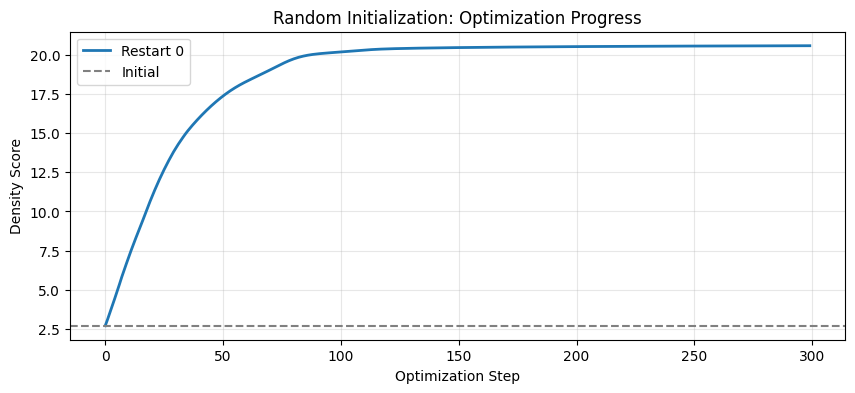

In [11]:
# new results
# Optimize from a random starting point
from torch import Tensor

seed_batch_pd = merged[merged[target_name] > 2.6].iloc[:, :-3]
seed_batch = Tensor(seed_batch_pd.values).to(device)

# New API returns OptimizationResult namedtuple with all details
result = model.optimize_latent(
    task_name=target_name,
    initial_input=seed_batch,
    mode="max",
    steps=300,
    lr=0.05,
    ae_task_name="reconstruction",
    optimize_space="latent",  # Use input space optimization (default)
)

final_scores = result.optimized_target[0, :, 0].detach().cpu().numpy()
initial_scores = result.initial_score[0, 0, 0].detach().cpu().item()
print("Random Initialization Results:")
print(f"  Initial score: {initial_scores:.4f}")
print(f"  Optimized scores (per restart): {final_scores}")
print(f"  Best improvement: {final_scores.max() - initial_scores:+.4f}")

# Plot optimization trajectory for best restart
best_idx = int(final_scores.argmax())
traj = result.trajectory[0, best_idx, :, 0].detach().cpu().numpy()
plt.figure(figsize=(10, 4))
plt.plot(traj, linewidth=2, label=f'Restart {best_idx}')
plt.axhline(initial_scores, color='gray', linestyle='--', label='Initial')
plt.xlabel('Optimization Step')
plt.ylabel('Density Score')
plt.title('Random Initialization: Optimization Progress')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Strategy 2: Perturbation Around a Known Point

If you have a known good sample, add perturbation to explore the neighborhood.

Baseline sample score: 2.3917
Perturbation 0.00: Score = 20.6456, Improvement vs baseline = +18.2539
Perturbation 0.05: Score = 20.6457, Improvement vs baseline = +18.2540
Perturbation 0.10: Score = 20.6458, Improvement vs baseline = +18.2541
Perturbation 0.20: Score = 20.6443, Improvement vs baseline = +18.2526
Perturbation 0.50: Score = 20.6439, Improvement vs baseline = +18.2522


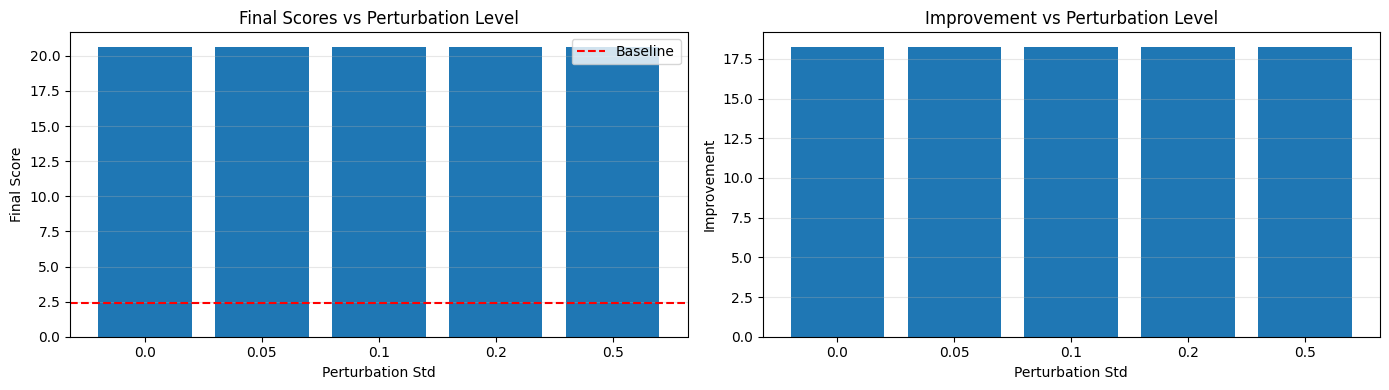

In [13]:
# Create a "known good sample" (from dataset)

with torch.no_grad():
    baseline_score = model(seed_batch)[target_name].mean().item()

print(f"Baseline sample score: {baseline_score:.4f}")

perturbation_levels = [0.0, 0.05, 0.1, 0.2, 0.5]
results_perturbation = []

for perturb_std in perturbation_levels:
    result = model.optimize_latent(
        task_name=target_name,
        initial_input=seed_batch,
        mode="max",
        steps=300,
        perturbation_std=perturb_std,
        ae_task_name="reconstruction",
        optimize_space="latent",  # Default: optimize input space
    )
    final_score = result.optimized_target[0, 0, 0].item()
    results_perturbation.append({"perturbation": perturb_std, "final_score": final_score})
    print(f"Perturbation {perturb_std:.2f}: Score = {final_score:.4f}, Improvement vs baseline = {final_score - baseline_score:+.4f}")

df_perturb = pd.DataFrame(results_perturbation)
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].bar(df_perturb['perturbation'].astype(str), df_perturb['final_score'])
axes[0].axhline(baseline_score, color='red', linestyle='--', label='Baseline')
axes[0].set_xlabel('Perturbation Std')
axes[0].set_ylabel('Final Score')
axes[0].set_title('Final Scores vs Perturbation Level')
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')

axes[1].bar(df_perturb['perturbation'].astype(str), df_perturb['final_score'] - baseline_score)
axes[1].axhline(0, color='gray', linestyle='-', linewidth=0.5)
axes[1].set_xlabel('Perturbation Std')
axes[1].set_ylabel('Improvement')
axes[1].set_title('Improvement vs Perturbation Level')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Strategy 3: Multi-Restart for Global Search

Try multiple random starts and pick the best result to avoid local optima.

Running optimization with 20 random restarts...
Best score: 20.5992 (restart 12)
Initial score: 2.8694
Statistics across 20 restarts:
  Score range: 20.5971 - 20.5992
  Mean score: 20.5983 ± 0.0006
  Best improvement: 17.7298


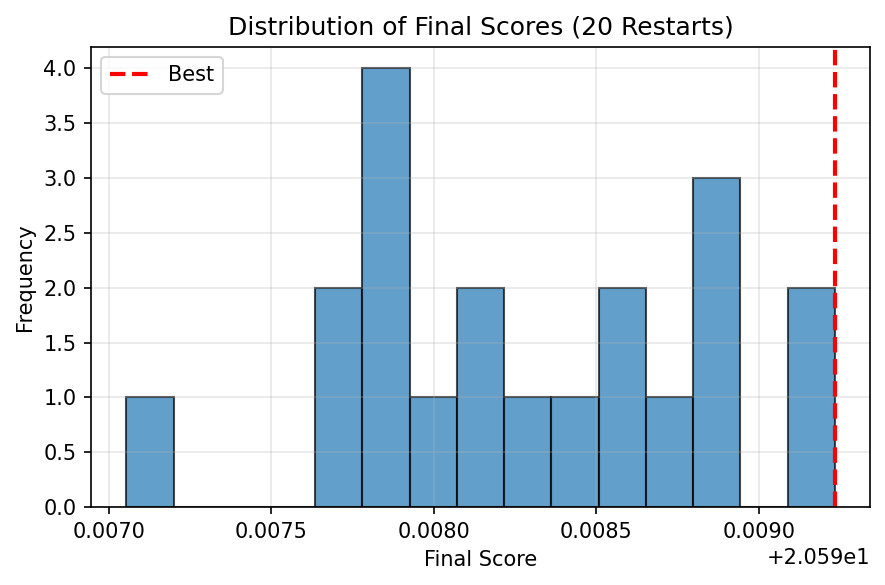

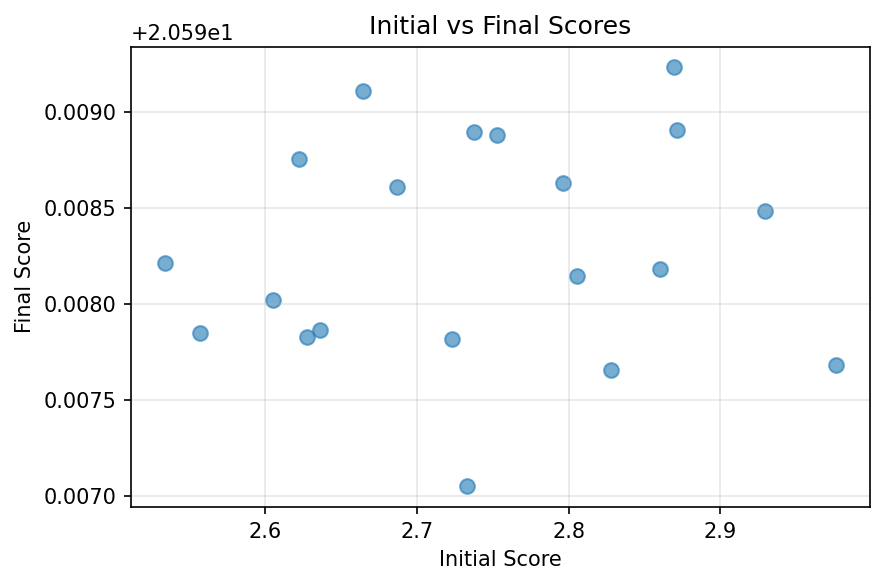

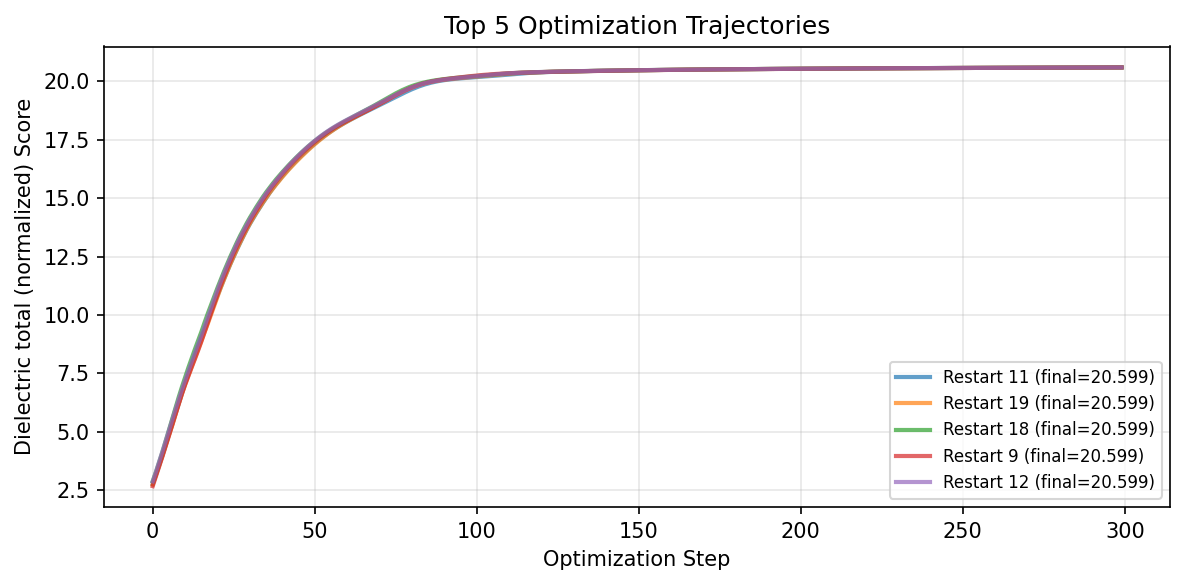

In [14]:
# Global search with multiple restarts
print("Running optimization with 20 random restarts...")

result = model.optimize_latent(
    task_name=target_name,
    initial_input=seed_batch,
    mode="max",
    steps=300,
    lr=0.05,
    num_restarts=20,
    perturbation_std=0.1,
    optimize_space="latent",
    ae_task_name="reconstruction",
)

scores = result.optimized_target[0, :, 0].detach().cpu().numpy()
initial_val = result.initial_score[0, :, 0].detach().cpu().numpy()
best_idx = int(scores.argmax())
print(f"Best score: {scores[best_idx]:.4f} (restart {best_idx})")
print(f"Initial score: {initial_val[best_idx]:.4f}")

print(f"Statistics across {len(scores)} restarts:")
print(f"  Score range: {scores.min():.4f} - {scores.max():.4f}")
print(f"  Mean score: {scores.mean():.4f} ± {scores.std():.4f}")
print(f"  Best improvement: {scores.max() - initial_val[best_idx]:.4f}")

# Plot 1: Distribution of final scores
plt.figure(figsize=(6, 4), dpi=150)
plt.hist(scores, bins=15, alpha=0.7, edgecolor="black")
plt.axvline(scores[best_idx], color="red", linestyle="--", linewidth=2, label="Best")
plt.xlabel("Final Score")
plt.ylabel("Frequency")
plt.title("Distribution of Final Scores (20 Restarts)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Initial vs Final Scores
plt.figure(figsize=(6, 4), dpi=150)
plt.scatter(initial_val, scores, alpha=0.6, s=50)
plt.xlabel("Initial Score")
plt.ylabel("Final Score")
plt.title("Initial vs Final Scores")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 3: Top 5 Optimization Trajectories
traj_multi = result.trajectory[0, :, :, 0].detach().cpu().numpy()  # (R, steps)
top_5 = np.argsort(scores)[-5:]
plt.figure(figsize=(8, 4), dpi=150)
for idx in top_5:
    plt.plot(traj_multi[idx], alpha=0.7, linewidth=2, label=f"Restart {idx} (final={scores[idx]:.3f})")
plt.xlabel("Optimization Step")
plt.ylabel(f"{target_name} Score")
plt.title("Top 5 Optimization Trajectories")
plt.legend(fontsize=8)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Analyzing the Reconstructed Descriptors

Let's compare the descriptors from different optimization strategies.

In [15]:
import joblib


joblib.dump(result, '../data/advanced_optimization_result.pkl.z')

['../data/advanced_optimization_result.pkl.z']

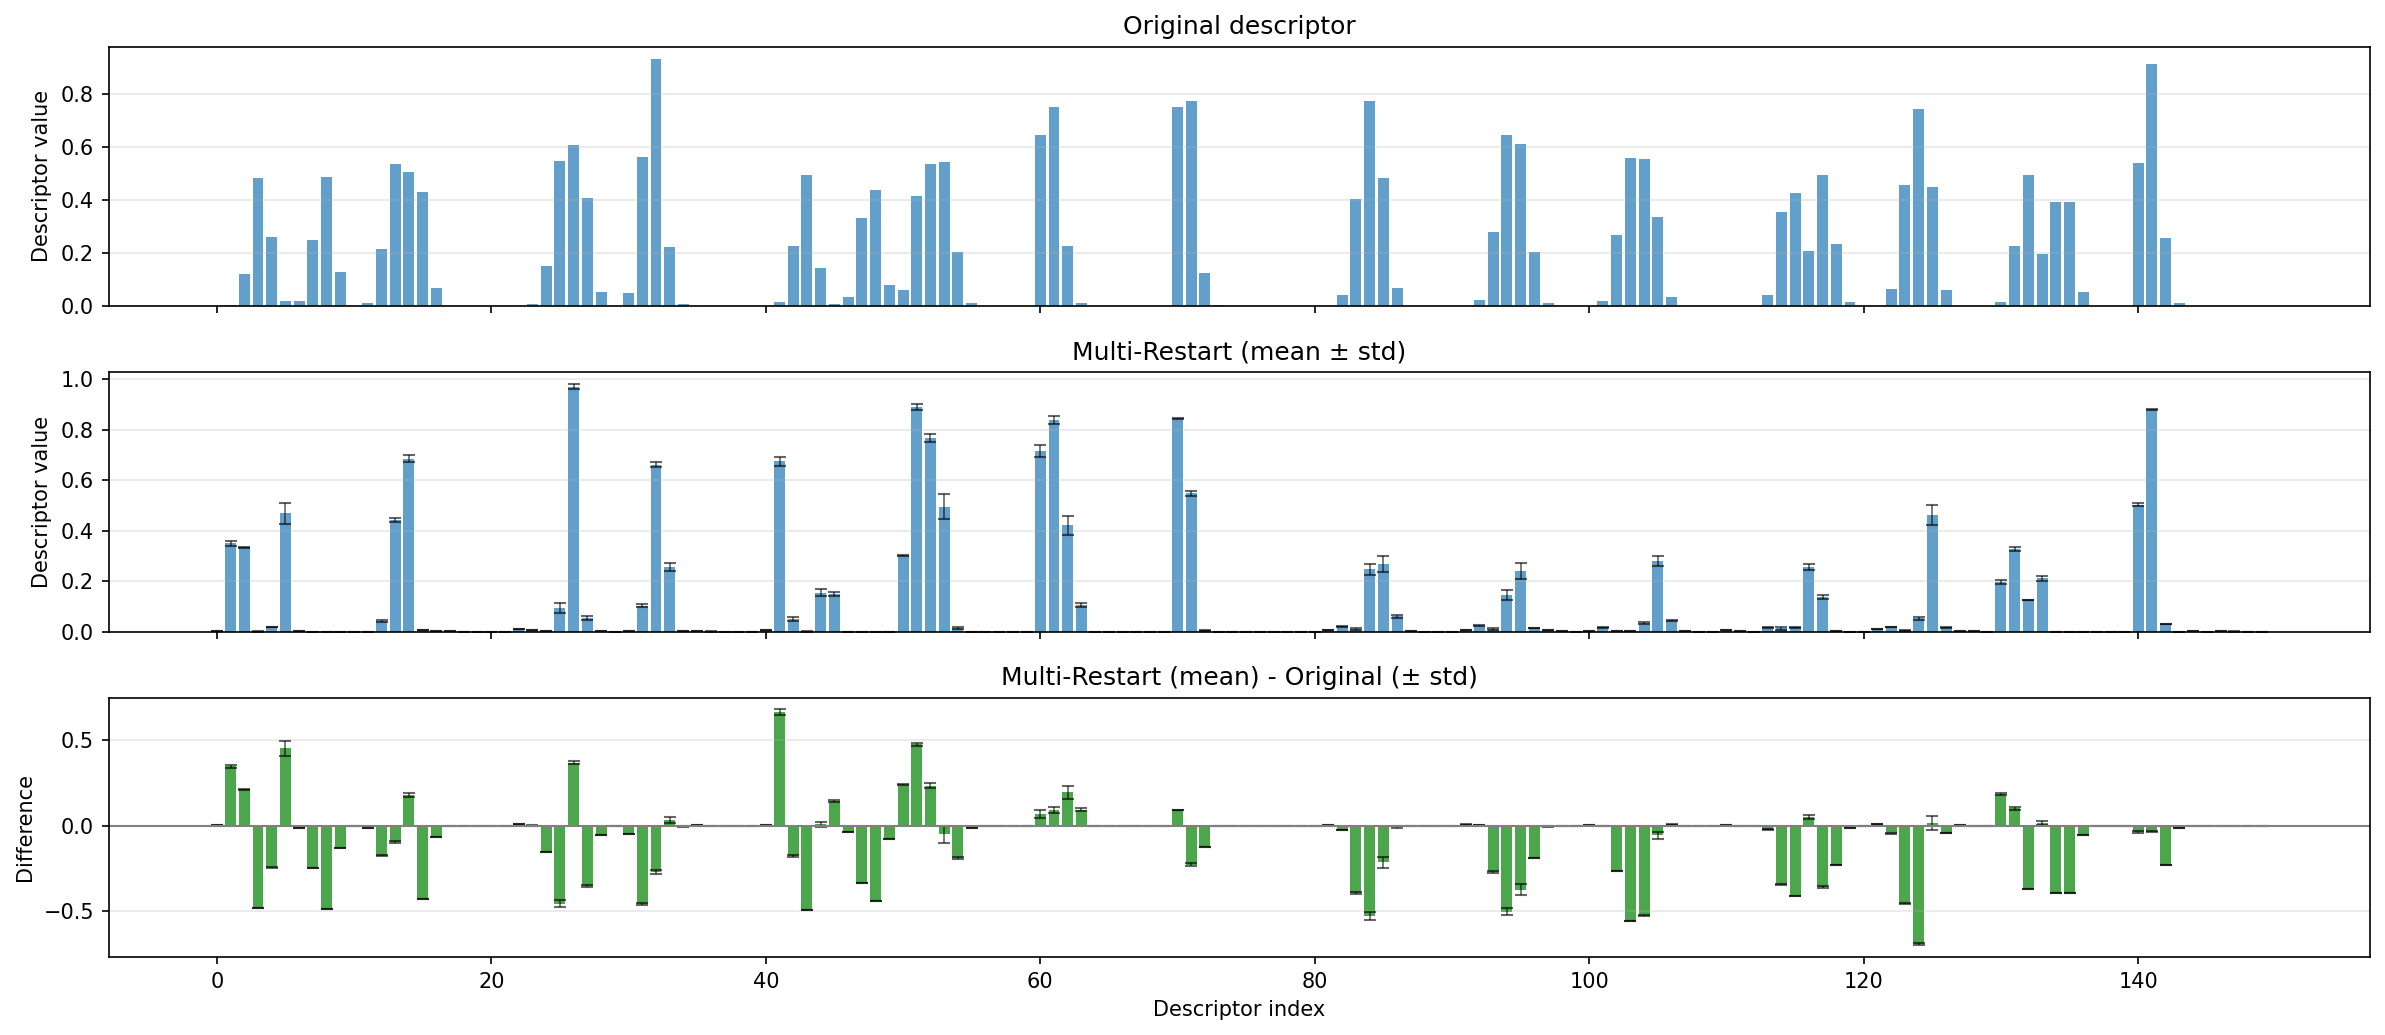

Descriptor statistics (first 100 features):
Original:
  Mean: 0.1751
  Std: 0.2410
  Range: [0.0000, 0.9319]
Multi-Restart (mean):
  Mean: 0.1082
  Std: 0.2208
  Range: [0.0000, 0.9716]


In [16]:
# Get reconstructed/optimized descriptors (pick best restart from previous multi-restart run)
best_multi_idx = int(result.optimized_target[0, :, 0].argmax())

# Get reconstructed/optimized descriptors from all restarts
all_multi_descriptors = result.optimized_input[0].cpu().numpy()  # shape: (num_restarts, input_dim)

descriptors_ = {
    'Original': seed_batch[0].cpu().numpy().flatten(),
    'Multi-Restart (mean)': all_multi_descriptors.mean(axis=0),
}

# Visualize first n_show features with error bars
n_show = 150
fig, axes = plt.subplots(3, 1, figsize=(16, 7), sharex=True, dpi=150)

# Original plot
axes[0].bar(range(n_show), descriptors_['Original'][:n_show], alpha=0.7)
axes[0].set_ylabel('Descriptor value')
axes[0].set_title('Original descriptor')
axes[0].grid(alpha=0.3, axis='y')

# Multi-restart mean with std as error bars
mean_vals = all_multi_descriptors.mean(axis=0)[:n_show]
std_vals = all_multi_descriptors.std(axis=0)[:n_show]
axes[1].bar(range(n_show), mean_vals, yerr=std_vals, alpha=0.7, capsize=3, error_kw={'linewidth': 0.8, 'alpha': 0.6})
axes[1].set_ylabel('Descriptor value')
axes[1].set_title('Multi-Restart (mean ± std)')
axes[1].grid(alpha=0.3, axis='y')

# Difference: Multi-Restart (mean) - Original with error bars
diff_vals = mean_vals - descriptors_['Original'][:n_show]
axes[2].bar(range(n_show), diff_vals, yerr=std_vals, alpha=0.7, capsize=3, error_kw={'linewidth': 0.8, 'alpha': 0.6}, color='green')
axes[2].axhline(0, color='gray', linestyle='-', linewidth=1)
axes[2].set_xlabel('Descriptor index')
axes[2].set_ylabel('Difference')
axes[2].set_title('Multi-Restart (mean) - Original (± std)')
axes[2].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Statistical comparison
print('Descriptor statistics (first 100 features):')
for name, desc in descriptors_.items():
    print(f"{name}:")
    print(f"  Mean: {np.mean(desc[:n_show]):.4f}")
    print(f"  Std: {np.std(desc[:n_show]):.4f}")
    print(f"  Range: [{np.min(desc[:n_show]):.4f}, {np.max(desc[:n_show]):.4f}]")

## Strategy Comparison: Input Space vs Latent Space Optimization

The model supports two optimization strategies:

1. **Input Space Optimization** (`optimize_space="input"`):
   - Directly optimizes the high-dimensional input features X
   - The encoder is used in every forward pass
   - Tanh constraint is applied at the FlexibleMultiTaskModel level on every step
   - ✅ **Recommended for general use**
   
2. **Latent Space Optimization** (`optimize_space="latent"`):
   - Encodes X once to get initial latent representation
   - Directly optimizes the low-dimensional latent space
   - Tanh is applied uniformly (same as training) on every step
   - ✅ **Now properly constrained with unified Tanh architecture**
   - **Requires an autoencoder task** for reconstruction

Let's compare both approaches and analyze their behavior under the new simplified architecture.

In [9]:
# Comparison: Input Space vs Latent Space Optimization
print("=" * 80)
print("COMPARISON: Input Space vs Latent Space Optimization")
print("=" * 80)
print(f"Starting from baseline score: {baseline_score:.4f}\n")

# Common parameters
num_restarts_compare = 20
perturbation_std_compare = 0.1
steps_compare = 200
lr_compare = 0.05

# Strategy 1: Input Space Optimization
print("Running Input Space Optimization (optimize_space='input')...")
import time
start_time = time.time()
result_input = model.optimize_latent(
    task_name=target_name,
    initial_input=seed_batch,
    mode="max",
    steps=steps_compare,
    lr=lr_compare,
    num_restarts=num_restarts_compare,
    perturbation_std=perturbation_std_compare,
    optimize_space="input",
)
time_input = time.time() - start_time

scores_input = result_input.optimized_target[0, :, 0].detach().cpu().numpy()
initial_input = result_input.initial_score[0, :, 0].detach().cpu().numpy()

print(f"✓ Completed in {time_input:.2f}s")
print(f"  Best score: {scores_input.max():.4f}")
print(f"  Mean score: {scores_input.mean():.4f} ± {scores_input.std():.4f}")
print(f"  Best improvement: {scores_input.max() - initial_input.mean():.4f}\n")

# Strategy 2: Latent Space Optimization
print("Running Latent Space Optimization (optimize_space='latent')...")
start_time = time.time()
result_latent = model.optimize_latent(
    task_name=target_name,
    initial_input=seed_batch,
    mode="max",
    steps=steps_compare,
    lr=lr_compare,
    num_restarts=num_restarts_compare,
    perturbation_std=perturbation_std_compare,
    ae_task_name="reconstruction",
    optimize_space="latent",
)
time_latent = time.time() - start_time

scores_latent = result_latent.optimized_target[0, :, 0].detach().cpu().numpy()
initial_latent = result_latent.initial_score[0, :, 0].detach().cpu().numpy()

print(f"✓ Completed in {time_latent:.2f}s")
print(f"  Best score: {scores_latent.max():.4f}")
print(f"  Mean score: {scores_latent.mean():.4f} ± {scores_latent.std():.4f}")
print(f"  Best improvement: {scores_latent.max() - initial_latent.mean():.4f}\n")

# Summary comparison
print("=" * 80)
print("INITIAL COMPARISON RESULTS")
print("=" * 80)
print(f"Optimization space:  Input={input_dim}D, Latent={latent_dim}D")
print(f"Time ratio (latent/input): {time_latent/time_input:.2f}x")
print("Best score improvement:")
print(f"  Input Space:  {scores_input.max() - initial_input.mean():+.4f}")
print(f"  Latent Space: {scores_latent.max() - initial_latent.mean():+.4f}")
print("\n⚠️  WARNING: Latent space shows suspiciously high scores!")
print("    This suggests unbounded growth - let's investigate further below.")
print("=" * 80)

COMPARISON: Input Space vs Latent Space Optimization
Starting from baseline score: 2.3917

Running Input Space Optimization (optimize_space='input')...
✓ Completed in 5.41s
  Best score: 13.0318
  Mean score: 12.1285 ± 0.5425
  Best improvement: 10.3389

Running Latent Space Optimization (optimize_space='latent')...
✓ Completed in 2.37s
  Best score: 20.5427
  Mean score: 20.5414 ± 0.0008
  Best improvement: 17.8482

INITIAL COMPARISON RESULTS
Optimization space:  Input=580D, Latent=128D
Time ratio (latent/input): 0.44x
Best score improvement:
  Input Space:  +10.3389
  Latent Space: +17.8482

⚠️  WARNING: Latent space shows suspiciously high scores!
    This suggests unbounded growth - let's investigate further below.


In [10]:

joblib.dump(result_input, '../data/advanced_optimization_result_input.pkl.z')
joblib.dump(result_latent, '../data/advanced_optimization_result_latent.pkl.z')

['../data/advanced_optimization_result_latent.pkl.z']

/var/folders/rw/27164gts5x58ct1t2mtrnlrc0000gn/T/ipykernel_86136/2864991000.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0, 1].boxplot(data_boxplot, labels=['Input Space', 'Latent Space'], patch_artist=True)


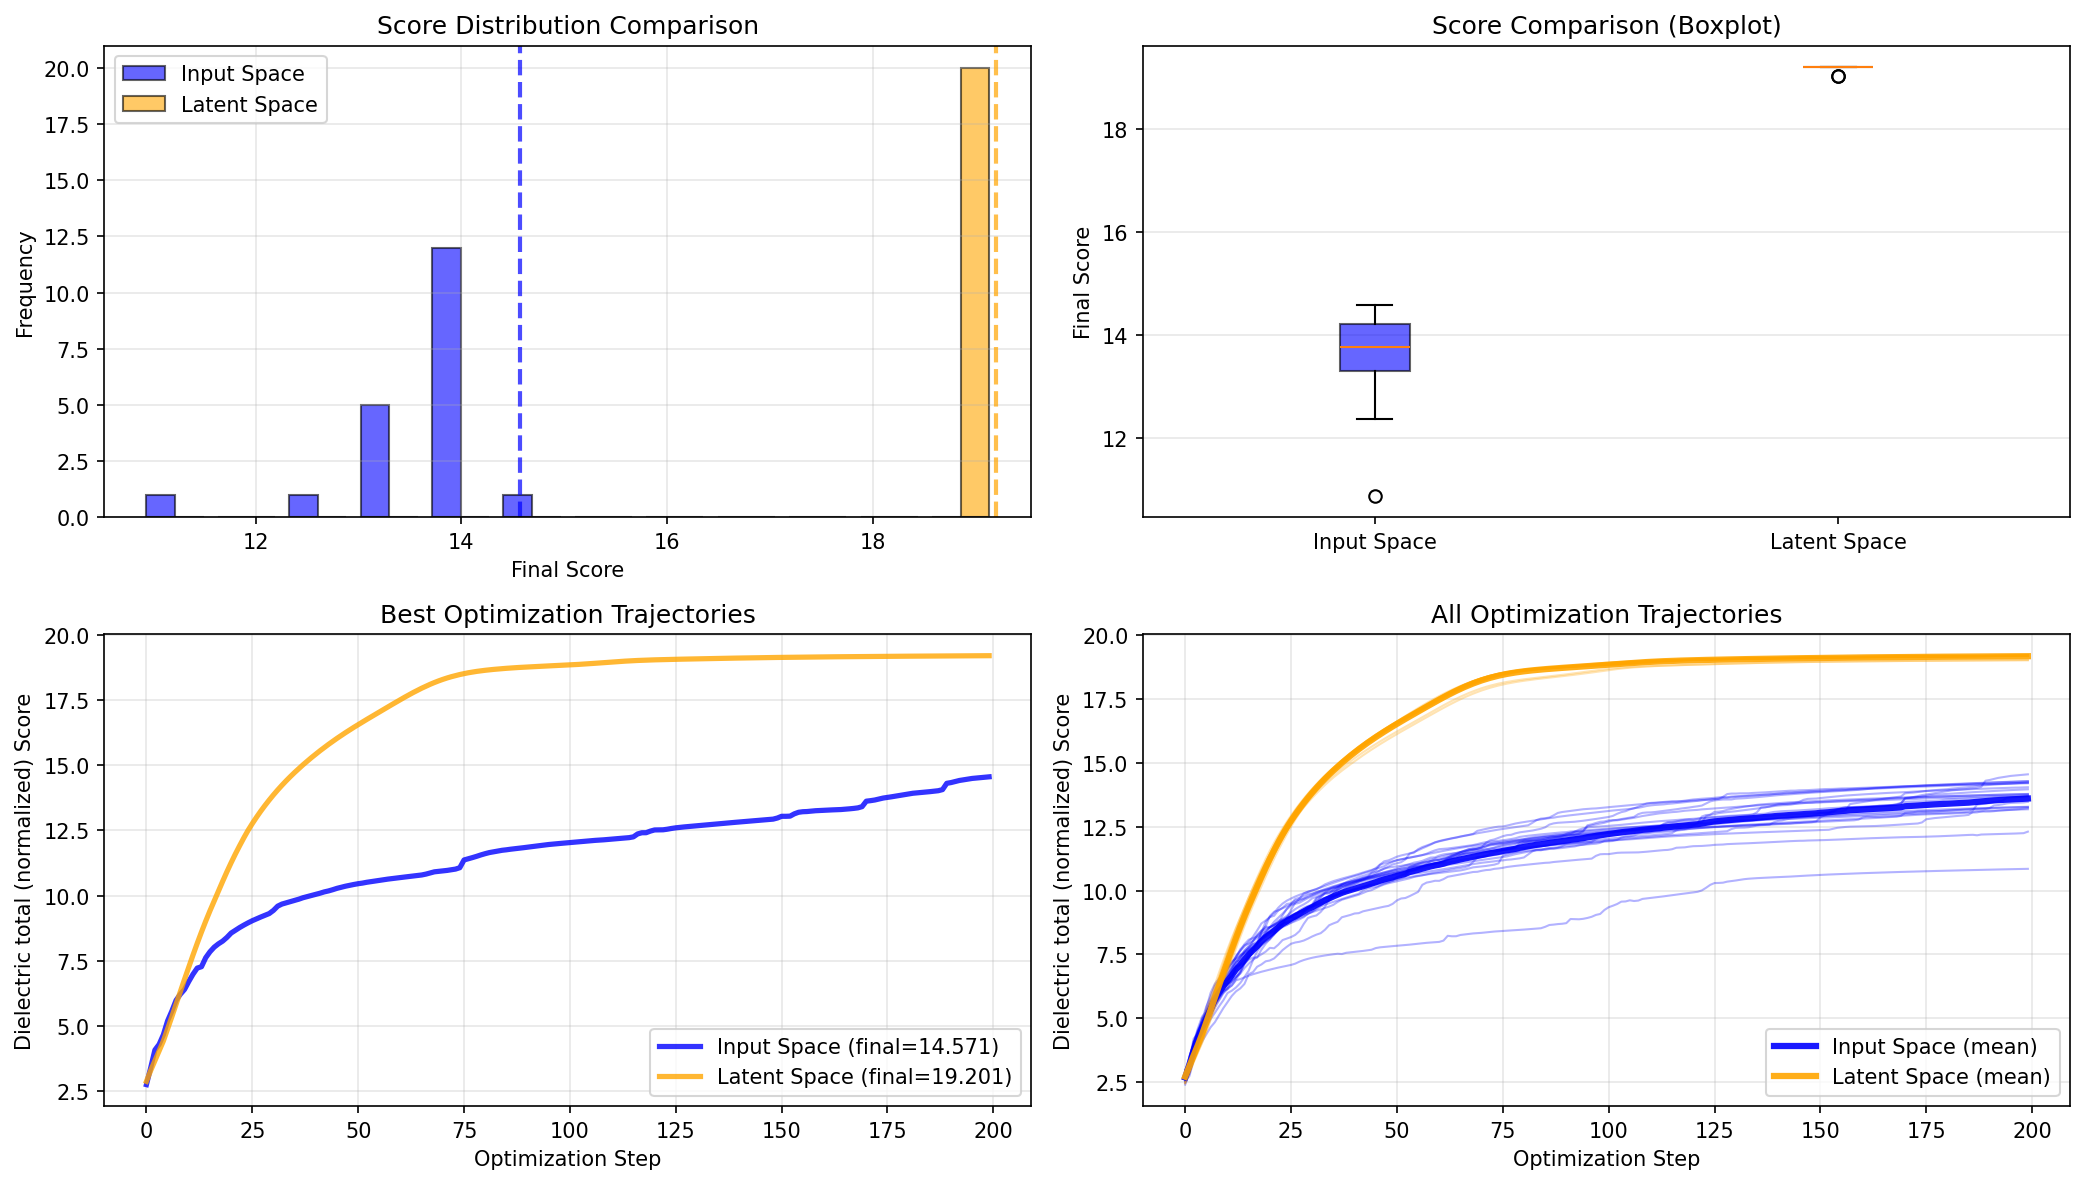


Reconstruction Quality Analysis:
Latent Space Optimization:
  Reconstruction MSE vs seed: 0.066208
  This measures how well the AE reconstructed the optimized latent back to input space

Tanh(latent) bounds verification:
  Input space:  [-1.0000, 1.0000] ✓
  Latent space: [-0.5555, 1.0000] ✓
  Both bounded to [-1, 1] as expected under unified Tanh architecture


/var/folders/rw/27164gts5x58ct1t2mtrnlrc0000gn/T/ipykernel_86136/2864991000.py:77: UserWarning: Using a target size (torch.Size([89, 580])) that is different to the input size (torch.Size([1, 580])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  recon_error = F.mse_loss(best_latent_opt, seed_batch).item()


In [53]:
# Visualize the comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 8), dpi=150)

# Plot 1: Score distributions
axes[0, 0].hist([scores_input, scores_latent], bins=12, alpha=0.6, label=['Input Space', 'Latent Space'],
                color=['blue', 'orange'], edgecolor='black')
axes[0, 0].axvline(scores_input.max(), color='blue', linestyle='--', linewidth=2, alpha=0.7)
axes[0, 0].axvline(scores_latent.max(), color='orange', linestyle='--', linewidth=2, alpha=0.7)
axes[0, 0].set_xlabel('Final Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Score Distribution Comparison')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: Box plot comparison
data_boxplot = [scores_input, scores_latent]
bp = axes[0, 1].boxplot(data_boxplot, labels=['Input Space', 'Latent Space'], patch_artist=True)
for patch, color in zip(bp['boxes'], ['blue', 'orange']):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
axes[0, 1].set_ylabel('Final Score')
axes[0, 1].set_title('Score Comparison (Boxplot)')
axes[0, 1].grid(alpha=0.3, axis='y')

# Plot 3: Optimization trajectories (best runs)
traj_input = result_input.trajectory[0, :, :, 0].detach().cpu().numpy()  # (R, steps)
traj_latent = result_latent.trajectory[0, :, :, 0].detach().cpu().numpy()  # (R, steps)

best_input_idx = int(scores_input.argmax())
best_latent_idx = int(scores_latent.argmax())

axes[1, 0].plot(traj_input[best_input_idx], linewidth=2.5, label=f'Input Space (final={scores_input[best_input_idx]:.3f})',
                color='blue', alpha=0.8)
axes[1, 0].plot(traj_latent[best_latent_idx], linewidth=2.5, label=f'Latent Space (final={scores_latent[best_latent_idx]:.3f})',
                color='orange', alpha=0.8)
axes[1, 0].set_xlabel('Optimization Step')
axes[1, 0].set_ylabel(f'{target_name} Score')
axes[1, 0].set_title('Best Optimization Trajectories')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Plot 4: All trajectories comparison
for idx in range(len(scores_input)):
    axes[1, 1].plot(traj_input[idx], alpha=0.3, color='blue', linewidth=1)
for idx in range(len(scores_latent)):
    axes[1, 1].plot(traj_latent[idx], alpha=0.3, color='orange', linewidth=1)

# Add mean trajectories
axes[1, 1].plot(traj_input.mean(axis=0), linewidth=3, color='blue', label='Input Space (mean)', alpha=0.9)
axes[1, 1].plot(traj_latent.mean(axis=0), linewidth=3, color='orange', label='Latent Space (mean)', alpha=0.9)
axes[1, 1].set_xlabel('Optimization Step')
axes[1, 1].set_ylabel(f'{target_name} Score')
axes[1, 1].set_title('All Optimization Trajectories')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Additional analysis: Reconstruction quality comparison
print("\nReconstruction Quality Analysis:")
print("=" * 60)

# For input space, we return the optimized input directly (no reconstruction needed)
# For latent space, we return AE-reconstructed input
with torch.no_grad():
    # Get best optimized inputs
    best_input_opt = result_input.optimized_input[0, best_input_idx:best_input_idx+1]
    best_latent_opt = result_latent.optimized_input[0, best_latent_idx:best_latent_idx+1]

    # Encode both and predict
    latent_from_input = model.encoder(best_input_opt)
    latent_from_latent_opt = model.encoder(best_latent_opt)

    # Check reconstruction error from latent space optimization
    # Note: best_latent_opt is already the AE-reconstructed input
    recon_error = F.mse_loss(best_latent_opt, seed_batch).item()

    print("Latent Space Optimization:")
    print(f"  Reconstruction MSE vs seed: {recon_error:.6f}")
    print("  This measures how well the AE reconstructed the optimized latent back to input space")

    # Verify Tanh bounds in both cases
    h_task_input = torch.tanh(latent_from_input)
    h_task_latent = torch.tanh(latent_from_latent_opt)

    print("\nTanh(latent) bounds verification:")
    print(f"  Input space:  [{h_task_input.min():.4f}, {h_task_input.max():.4f}] ✓")
    print(f"  Latent space: [{h_task_latent.min():.4f}, {h_task_latent.max():.4f}] ✓")
    print("  Both bounded to [-1, 1] as expected under unified Tanh architecture")

print("=" * 60)